In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Load dataset
file_path = r"E:\Hilary\ESG\Group Project\US_emissions.csv"
df = pd.read_csv(file_path)

(df.head())


,year,parent_entity,Stock Ticker,US_Company,parent_type,reporting_entity,commodity,production_value,production_unit,product_emissions_MtCO2,flaring_emissions_MtCO2,venting_emissions_MtCO2,own_fuel_use_emissions_MtCO2,fugitive_methane_emissions_MtCO2e,total_operational_emissions_MtCO2e,total_emissions_MtCO2e,source
0,2023,CEIX,ARCH,1,Investor-owned Company,Arch Resources,Metallurgical Coal,8.436905,Million tonnes/yr,22.488549,0.0,0.0,0.0,2.540516,2.540516,25.029065,"Arch Resources Form 10-K for 2022, page 15."
1,2023,Arch Resources,ARCH,1,Investor-owned Company,Arch Resources,Thermal Coal,2.630863,Million tonnes/yr,5.600909,0.0,0.0,0.0,0.632731,0.632731,6.233640,"Arch Resources Form 10-K for 2022, page 15."
2,2023,Arch Resources,ARCH,1,Investor-owned Company,Arch Resources,Sub-Bituminous Coal,56.971786,Million tonnes/yr,103.355221,0.0,0.0,0.0,11.675968,11.675968,115.031189,"Arch Resources Form 10-K for 2022, page 15."
3,2022,Arch Resources,ARCH,1,Investor-owned Company,Arch Resources,Metallurgical Coal,7.076114,Million tonnes/yr,18.861364,0.0,0.0,0.0,2.130755,2.130755,20.992119,"Arch Resources Form 10-K for 2022, page 15."
4,2022,Arch Resources,ARCH,1,Investor-owned Company,Arch Resources,Thermal Coal,3.900934,Million tonnes/yr,8.304797,0.0,0.0,0.0,0.938187,0.938187,9.242984,"Arch Resources Form 10-K for 2022, page 15."


In [3]:
df = df[['year', 'parent_entity', 'total_emissions_MtCO2e', 'total_operational_emissions_MtCO2e', 'product_emissions_MtCO2']]

# Filter data for years 2000-2023 (historical)
df = df[(df['year'] >= 2000)]

# Identify top 5 emitting companies based on total emissions
top_emitters = df.groupby("parent_entity")["total_emissions_MtCO2e"].sum().nlargest(5)

# Print the top 5 emitting companies
print("Top 5 Emitting Companies):")
print(top_emitters)

Top 5 Emitting Companies):
parent_entity
Chevron                          11429.652212
Peabody Energy                   10535.876905
ConocoPhillips                    6856.582116
Arch Resources                    5647.972672
Alpha Metallurgical Resources     4894.818306
Name: total_emissions_MtCO2e, dtype: float64


In [4]:
# Standardize parent entity names (strip spaces and lowercase)
df['parent_entity'] = df['parent_entity'].str.strip().str.lower()

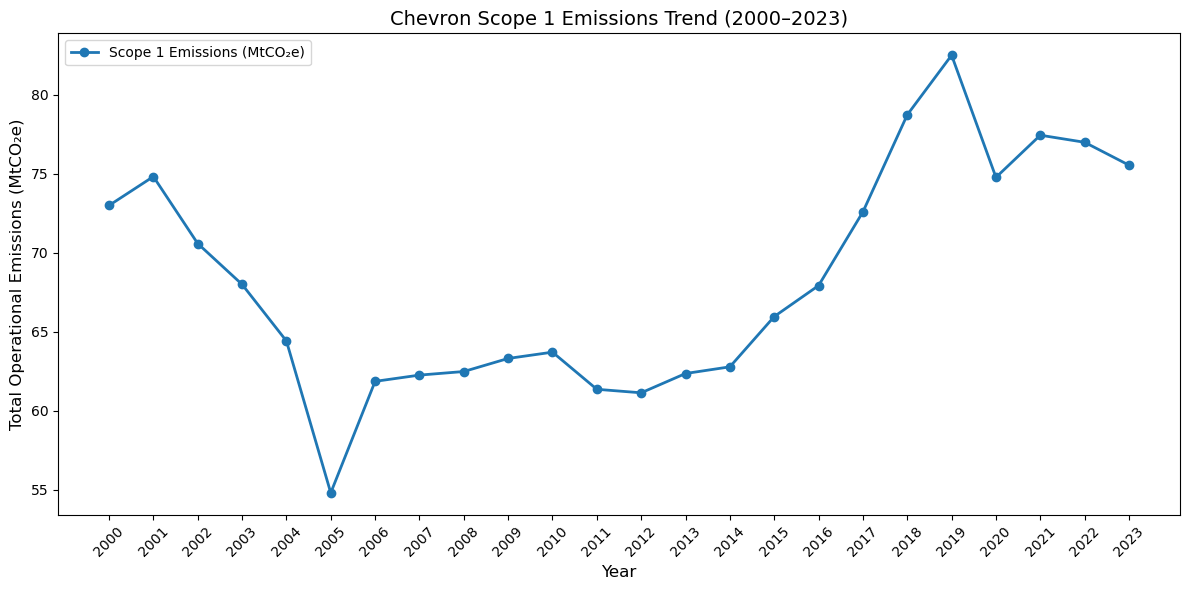

In [5]:
# Filter for Chevron's data from 2000–2023 
chevron_data = df[
    (df['parent_entity'].str.lower() == "chevron") &
    (df['year'] >= 2000) &
    (df['year'] <= 2023)
]

# Group by year and sum Scope 1 emissions
chevron_annual = chevron_data.groupby('year')['total_operational_emissions_MtCO2e'].sum().reset_index()

# Plot historical trend
plt.figure(figsize=(12, 6))
plt.plot(
    chevron_annual['year'],
    chevron_annual['total_operational_emissions_MtCO2e'],
    marker='o',
    linestyle='-',
    linewidth=2,
    label='Scope 1 Emissions (MtCO₂e)'
)
plt.title('Chevron Scope 1 Emissions Trend (2000–2023)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Operational Emissions (MtCO₂e)', fontsize=12)
plt.xticks(chevron_annual['year'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
chevron_annual

,year,total_operational_emissions_MtCO2e
0,2000,72.978297
1,2001,74.806981
2,2002,70.569818
3,2003,67.985338
4,2004,64.404117
5,2005,54.794942
6,2006,61.848639
7,2007,62.245091
8,2008,62.471411
9,2009,63.298805


In [20]:
# Assume chevron_annual has columns: ['year', 'total_operational_emissions_MtCO2e']
chevron_annual = chevron_annual.reset_index()  # In case it was already indexed
chevron_annual.set_index('year', inplace=True)

# Fit ARIMA model to total operational emissions (Scope 1)
model = ARIMA(chevron_annual['total_operational_emissions_MtCO2e'], order=(1, 0, 1))
model_fit = model.fit()

# Forecast for 2024–2030
forecast_years = np.arange(2024, 2031)
forecast_values = model_fit.forecast(steps=len(forecast_years))

# Build full year range
all_years = np.arange(2000, 2031)
combined_df = pd.DataFrame({'year': all_years})

# Merge historical data
# Reset index again to bring 'year' back as a column
historical_df = chevron_annual.reset_index()[['year', 'total_operational_emissions_MtCO2e']]
combined_df = combined_df.merge(historical_df, on='year', how='left')

# Merge forecasted data
forecast_df = pd.DataFrame({
    'year': forecast_years,
    'forecasted_emissions': forecast_values
})
combined_df = combined_df.merge(forecast_df, on='year', how='left')

# View result
print(combined_df)

    year  total_operational_emissions_MtCO2e  forecasted_emissions
0   2000                           72.978297                   NaN
1   2001                           74.806981                   NaN
2   2002                           70.569818                   NaN
3   2003                           67.985338                   NaN
4   2004                           64.404117                   NaN
5   2005                           54.794942                   NaN
6   2006                           61.848639                   NaN
7   2007                           62.245091                   NaN
8   2008                           62.471411                   NaN
9   2009                           63.298805                   NaN
10  2010                           63.696633                   NaN
11  2011                           61.346956                   NaN
12  2012                           61.124850                   NaN
13  2013                           62.345206                  

C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next v

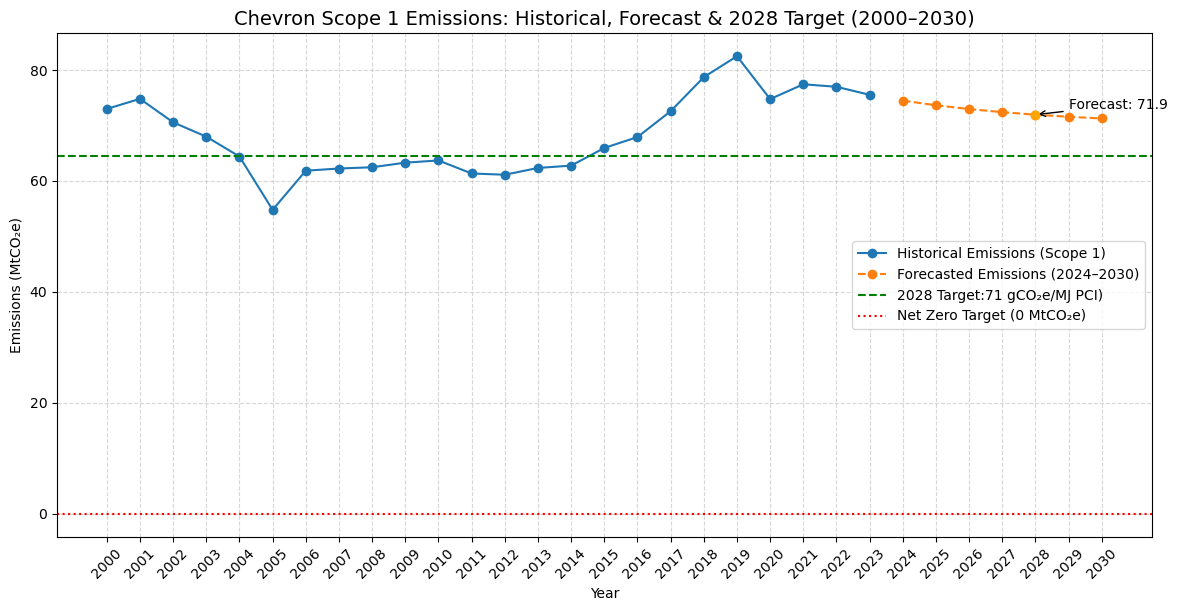

In [22]:
# Filter data to only show up to 2030
plot_df = combined_df[combined_df['year'] <= 2030]

# Calculate 2028 target from 2016 baseline (5% reduction)
baseline_2016 = plot_df.loc[plot_df['year'] == 2016, 'total_operational_emissions_MtCO2e'].values[0]
target_2028 = baseline_2016 * 0.95

# Get forecasted 2028 value
forecast_2028 = plot_df.loc[plot_df['year'] == 2028, 'forecasted_emissions'].values[0]

# Plotting
plt.figure(figsize=(12, 6))

# Historical
plt.plot(
    plot_df['year'],
    plot_df['total_operational_emissions_MtCO2e'],
    label='Historical Emissions (Scope 1)',
    marker='o'
)

# Forecasted
plt.plot(
    plot_df['year'],
    plot_df['forecasted_emissions'],
    label='Forecasted Emissions (2024–2030)',
    marker='o',
    linestyle='--'
)

# 2028 Target line in the legend
plt.axhline(
    y=target_2028,
    color='green',
    linestyle='--',
    label=f'2028 Target:71 gCO₂e/MJ PCI)'
)

# Annotate forecast for 2028
plt.scatter(2028, forecast_2028, color='orange', zorder=5)
plt.annotate(
    f'Forecast: {forecast_2028:.1f}',
    xy=(2028, forecast_2028),
    xytext=(2029, forecast_2028 + 1),
    arrowprops=dict(arrowstyle='->', lw=1),
    fontsize=10
)

# Net zero line (optional visual reference)
plt.axhline(y=0, color='red', linestyle=':', label='Net Zero Target (0 MtCO₂e)')

# Final chart formatting
plt.title('Chevron Scope 1 Emissions: Historical, Forecast & 2028 Target (2000–2030)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Emissions (MtCO₂e)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xticks(plot_df['year'], rotation=45)
plt.show()


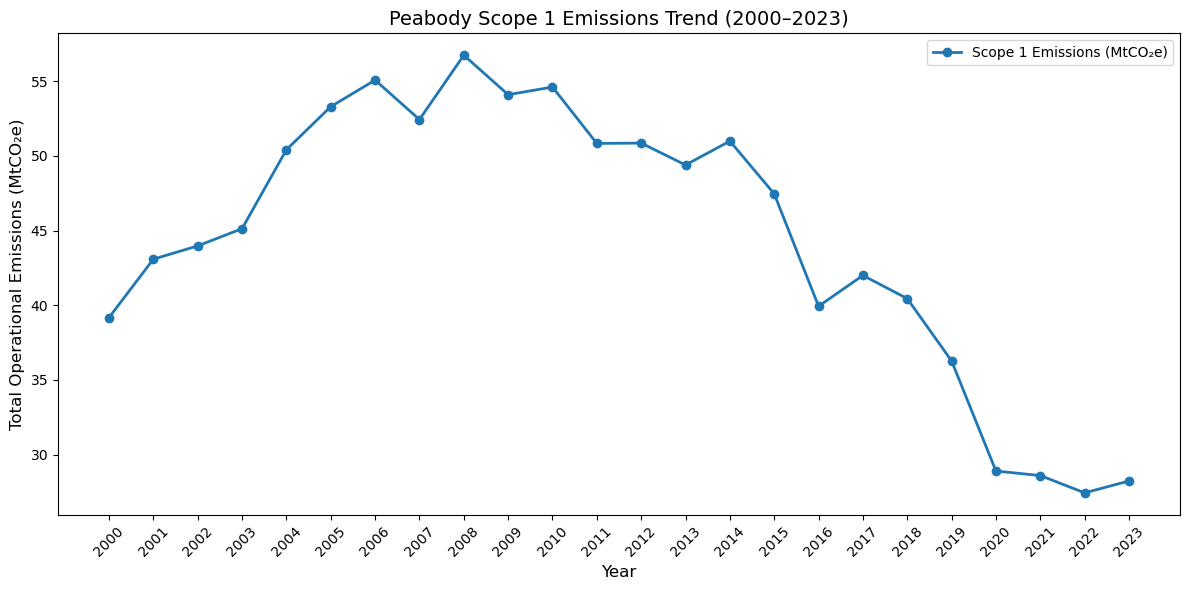

In [9]:
# Filter for Peabody's data from 2000–2023 
peabody_data = df[
    (df['parent_entity'].str.contains("Peabody", case=False)) &
    (df['year'] >= 2000) & (df['year'] <= 2023)
]

# Group by year and sum Scope 1 emissions
peabody_annual = peabody_data.groupby('year')['total_operational_emissions_MtCO2e'].sum().reset_index()

# Plot historical trend for Peabody
plt.figure(figsize=(12, 6))
plt.plot(
    peabody_annual['year'],
    peabody_annual['total_operational_emissions_MtCO2e'],
    marker='o',
    linestyle='-',
    linewidth=2,
    label='Scope 1 Emissions (MtCO₂e)'
)
plt.title('Peabody Scope 1 Emissions Trend (2000–2023)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Operational Emissions (MtCO₂e)', fontsize=12)
plt.xticks(peabody_annual['year'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
peabody_annual.rename(columns={'total_operational_emissions_MtCO2e': 'scope1_emissions_MtCO2e'}, inplace=True)

peabody_ts = peabody_annual.set_index('year')['scope1_emissions_MtCO2e']

model = ARIMA(peabody_ts, order=(2, 1, 2))
model_fit = model.fit()

#  Forecast from 2024 to 2030
forecast_steps = 2030 - 2023
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = list(range(2024, 2031))  
forecast_values = forecast.predicted_mean.to_numpy()

forecast_df = pd.DataFrame({
    'year': forecast_index,
    'forecasted_emissions': forecast_values
})

# Combine historical + forecast data into single table

# Create a DataFrame of all years from 2000 to 2030
all_years = pd.DataFrame({'year': range(2000, 2031)})

# Merge the historical data (left join)
combined_df = all_years.merge(peabody_annual, on='year', how='left')

# Merge the forecast data (left join)
combined_df = combined_df.merge(forecast_df, on='year', how='left')

# Display final table
print(combined_df)

    year  scope1_emissions_MtCO2e  forecasted_emissions
0   2000                39.178009                   NaN
1   2001                43.086926                   NaN
2   2002                43.975316                   NaN
3   2003                45.130224                   NaN
4   2004                50.416145                   NaN
5   2005                53.303414                   NaN
6   2006                55.080194                   NaN
7   2007                52.437233                   NaN
8   2008                56.745926                   NaN
9   2009                54.102965                   NaN
10  2010                54.613789                   NaN
11  2011                50.838131                   NaN
12  2012                50.860341                   NaN
13  2013                49.394497                   NaN
14  2014                50.993599                   NaN
15  2015                47.462248                   NaN
16  2016                39.933141               

C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next v

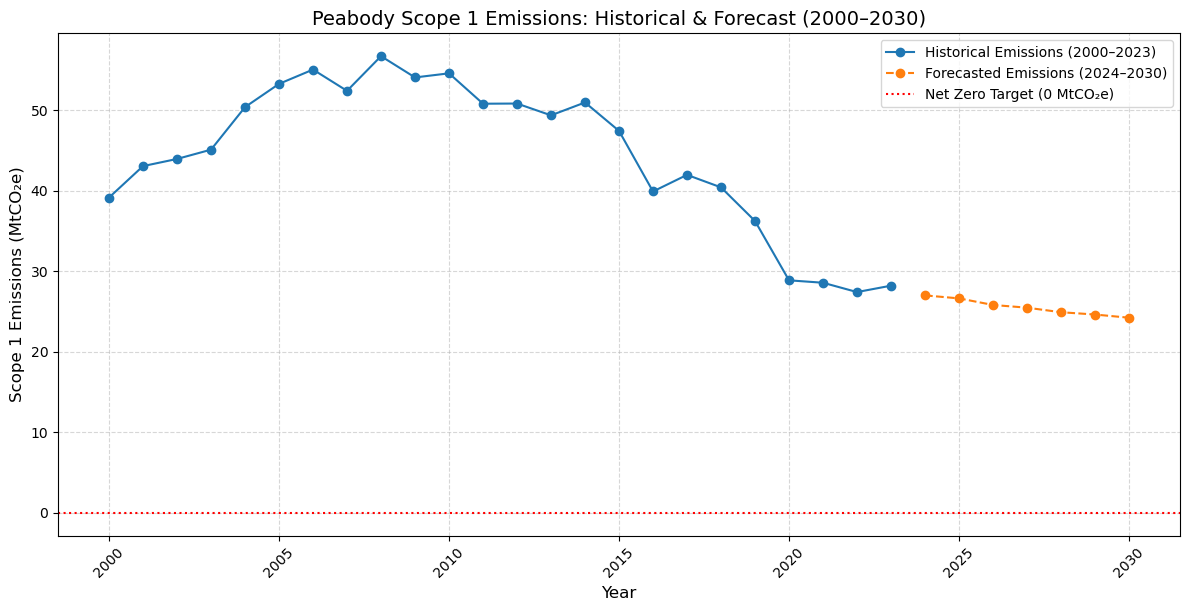

In [11]:
plt.figure(figsize=(12, 6))

# Plot historical emissions (2000–2023)
plt.plot(
    combined_df['year'],
    combined_df['scope1_emissions_MtCO2e'],
    label='Historical Emissions (2000–2023)',
    marker='o',
    linestyle='-'
)

# Plot forecasted emissions (2024–2030)
plt.plot(
    combined_df['year'],
    combined_df['forecasted_emissions'],
    label='Forecasted Emissions (2024–2030)',
    marker='o',
    linestyle='--'
)

# Net zero line (reference)
plt.axhline(y=0, color='red', linestyle=':', label='Net Zero Target (0 MtCO₂e)')

# Chart formatting
plt.title('Peabody Scope 1 Emissions: Historical & Forecast (2000–2030)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Scope 1 Emissions (MtCO₂e)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

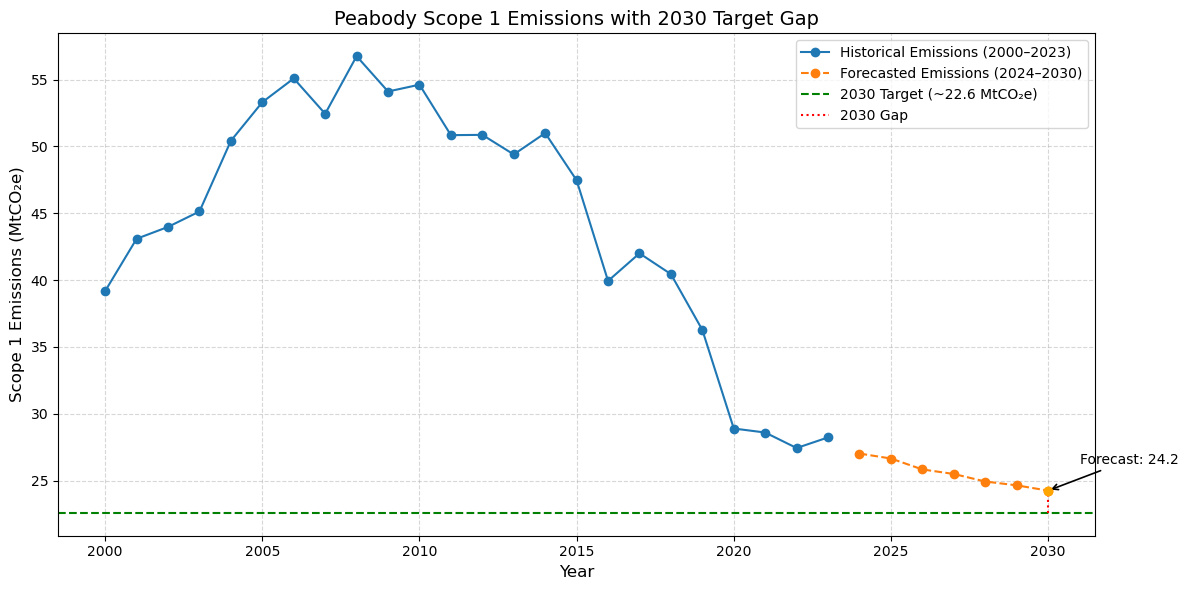

In [12]:
import matplotlib.pyplot as plt

# Get 2023 value from combined_df
emissions_2023 = combined_df.loc[combined_df['year'] == 2023, 'scope1_emissions_MtCO2e'].values[0]

# Calculate 2030 target (20% reduction from 2023)
target_2030 = 0.8 * emissions_2023

# Get forecasted 2030 emissions
forecast_2030 = combined_df.loc[combined_df['year'] == 2030, 'forecasted_emissions'].values[0]

plt.figure(figsize=(12, 6))

# Plot historical emissions
plt.plot(
    combined_df['year'],
    combined_df['scope1_emissions_MtCO2e'],
    label='Historical Emissions (2000–2023)',
    marker='o',
    linestyle='-'
)

# Plot forecasted emissions
plt.plot(
    combined_df['year'],
    combined_df['forecasted_emissions'],
    label='Forecasted Emissions (2024–2030)',
    marker='o',
    linestyle='--'
)

# 2030 Target line
plt.axhline(y=target_2030, color='green', linestyle='--', label=f'2030 Target (~{target_2030:.1f} MtCO₂e)')

# Annotate the forecasted 2030 value and the gap
plt.scatter(2030, forecast_2030, color='orange', zorder=5)
plt.annotate(
    f'Forecast: {forecast_2030:.1f}',
    xy=(2030, forecast_2030),
    xytext=(2031, forecast_2030 + 2),
    arrowprops=dict(arrowstyle='->', lw=1.2),
    fontsize=10
)

# Highlight the gap
plt.vlines(x=2030, ymin=target_2030, ymax=forecast_2030, colors='red', linestyles='dotted', label='2030 Gap')

# Final touches
plt.title('Peabody Scope 1 Emissions with 2030 Target Gap', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Scope 1 Emissions (MtCO₂e)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [13]:
# Filter ConocoPhillips data from 2000–2023
conoco_data = df[
    (df['parent_entity'].str.contains("ConocoPhillips", case=False)) &
    (df['year'] >= 2000) & (df['year'] <= 2023)
]

In [14]:
# Group by year and sum Scope 1 emissions
conoco_annual = (
    conoco_data
    .groupby('year')['total_operational_emissions_MtCO2e']
    .sum()
    .reset_index()
    .rename(columns={'total_operational_emissions_MtCO2e': 'scope1_emissions_MtCO2e'})
)

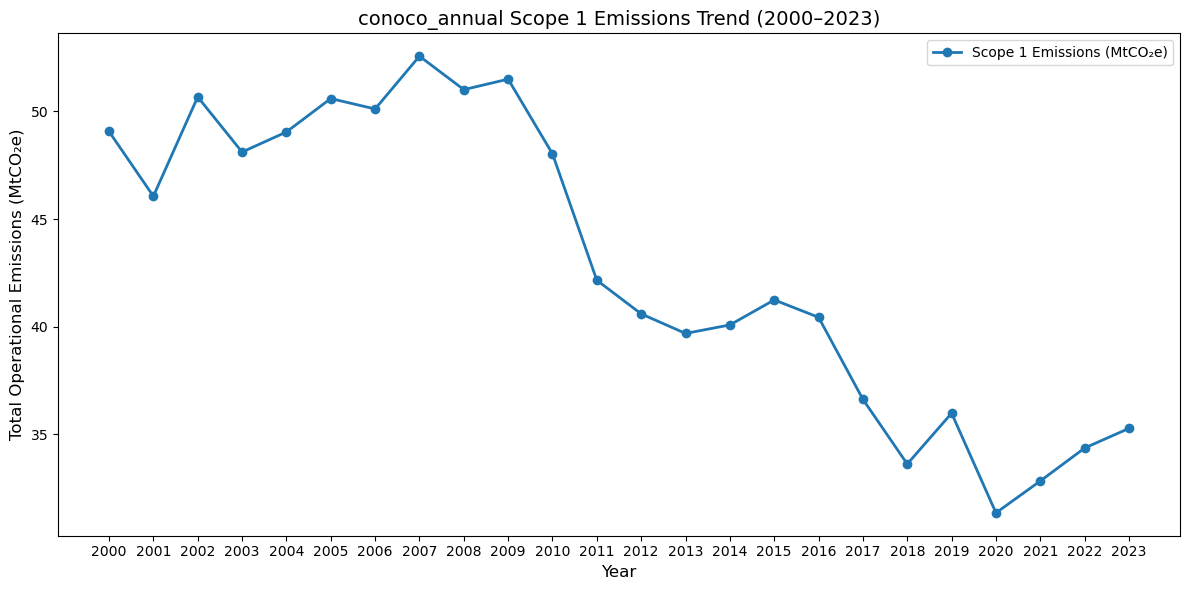

In [15]:
# Plot historical trend for Peabody
plt.figure(figsize=(12, 6))
plt.plot(
    conoco_annual['year'],
    conoco_annual['scope1_emissions_MtCO2e'],
    marker='o',
    linestyle='-',
    linewidth=2,
    label='Scope 1 Emissions (MtCO₂e)'
)
plt.title('conoco_annual Scope 1 Emissions Trend (2000–2023)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Operational Emissions (MtCO₂e)', fontsize=12)
plt.xticks(conoco_annual['year'])
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Fit ARIMA model
conoco_ts = conoco_annual.set_index('year')['scope1_emissions_MtCO2e']
model = ARIMA(conoco_ts, order=(2,2,2))
model_fit = model.fit()

# Forecast from 2024 to 2030
forecast_years = list(range(2024, 2031))
forecast_steps = len(forecast_years)
forecast_values = model_fit.get_forecast(steps=forecast_steps).predicted_mean.to_numpy()

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'year': forecast_years,
    'forecasted_emissions': forecast_values
})

# Historical DataFrame
historical_df = conoco_annual.copy()
historical_df['forecasted_emissions'] = np.nan

# Forecast DataFrame (fill historical column with NaNs)
forecast_df['scope1_emissions_MtCO2e'] = np.nan

# Combine both
combined_df = pd.concat([historical_df, forecast_df], ignore_index=True).sort_values(by='year').reset_index(drop=True)


# Get 2016 baseline and 2030 forecast
baseline_2016 = combined_df.loc[combined_df['year'] == 2016, 'scope1_emissions_MtCO2e'].values[0]
target_2030 = 0.5 * baseline_2016
forecast_2030 = combined_df.loc[combined_df['year'] == 2030, 'forecasted_emissions'].values[0]
print(combined_df)

C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


    year  scope1_emissions_MtCO2e  forecasted_emissions
0   2000                49.069665                   NaN
1   2001                46.062372                   NaN
2   2002                50.674242                   NaN
3   2003                48.113282                   NaN
4   2004                49.047068                   NaN
5   2005                50.598505                   NaN
6   2006                50.114517                   NaN
7   2007                52.566829                   NaN
8   2008                51.013223                   NaN
9   2009                51.499127                   NaN
10  2010                48.029139                   NaN
11  2011                42.159313                   NaN
12  2012                40.598833                   NaN
13  2013                39.689726                   NaN
14  2014                40.084214                   NaN
15  2015                41.245631                   NaN
16  2016                40.440161               

C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


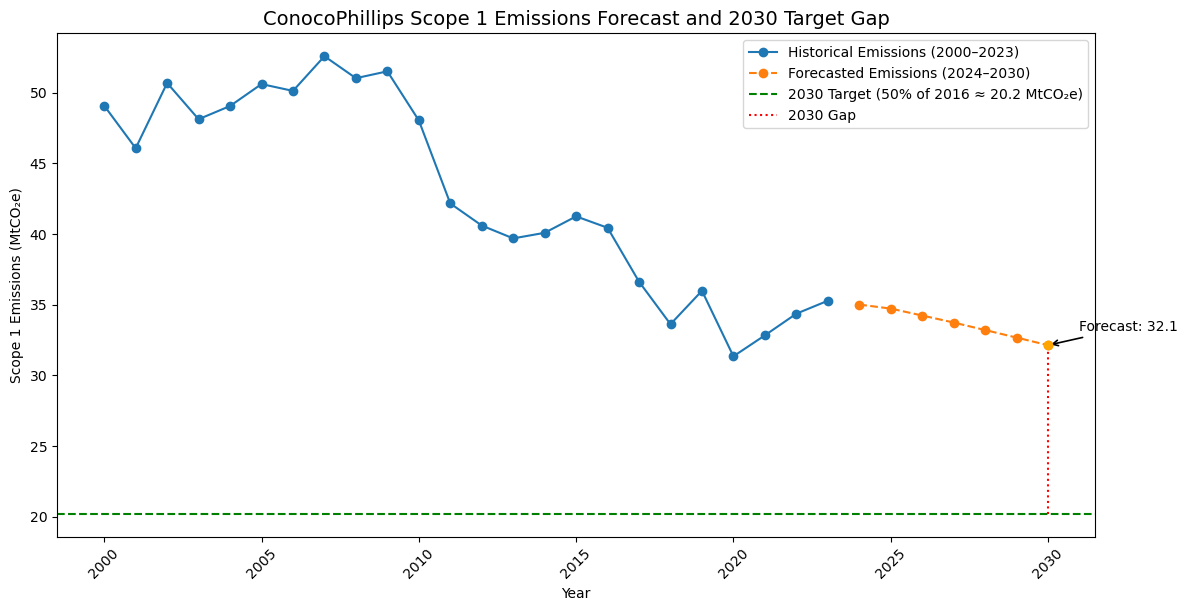

In [17]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(combined_df['year'], combined_df['scope1_emissions_MtCO2e'], label='Historical Emissions (2000–2023)', marker='o')
plt.plot(combined_df['year'], combined_df['forecasted_emissions'], label='Forecasted Emissions (2024–2030)', marker='o', linestyle='--')

# 2030 target line
plt.axhline(y=target_2030, color='green', linestyle='--', label=f'2030 Target (50% of 2016 ≈ {target_2030:.1f} MtCO₂e)')

# Annotate forecast
plt.scatter(2030, forecast_2030, color='orange', zorder=5)
plt.annotate(
    f'Forecast: {forecast_2030:.1f}',
    xy=(2030, forecast_2030),
    xytext=(2031, forecast_2030 + 1),
    arrowprops=dict(arrowstyle='->', lw=1.2),
    fontsize=10
)

# Gap indicator
plt.vlines(x=2030, ymin=target_2030, ymax=forecast_2030, colors='red', linestyles='dotted', label='2030 Gap')

# Chart formatting
plt.title('ConocoPhillips Scope 1 Emissions Forecast and 2030 Target Gap', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Scope 1 Emissions (MtCO₂e)')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

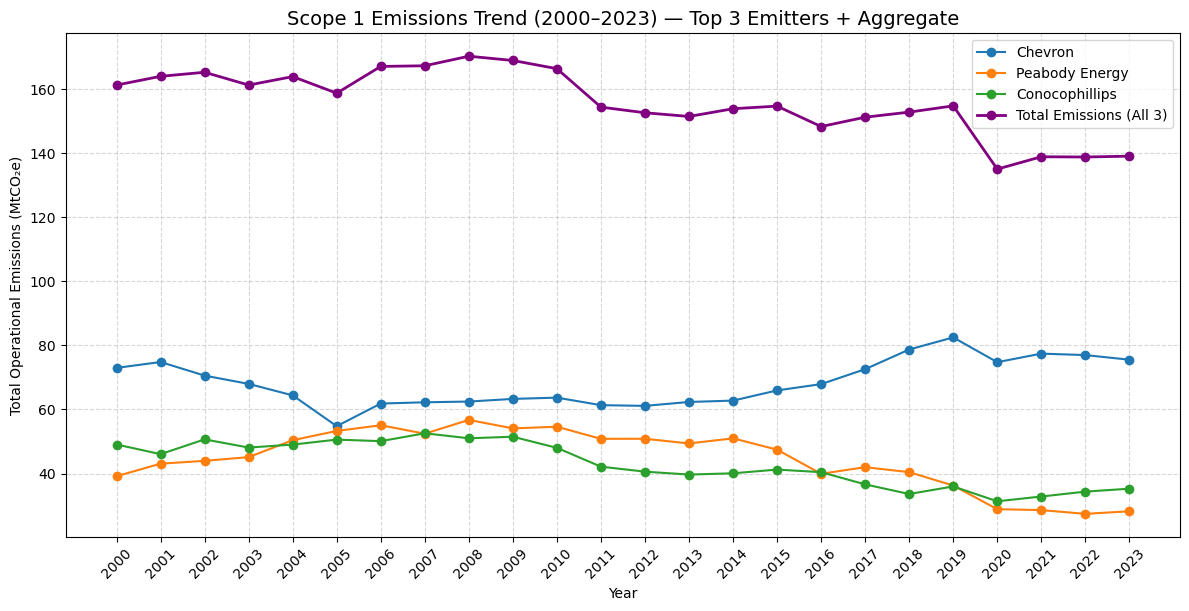

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Define top 3 emitter names (ensure case-insensitive match)
top_emitters = ["chevron", "peabody energy", "conocophillips"]

# Normalize casing in parent_entity
df['parent_entity'] = df['parent_entity'].str.lower()

# Filter and clean data
df_filtered = df[
    (df['parent_entity'].isin(top_emitters)) &
    (df['year'] >= 2000) & (df['year'] <= 2023)
]

# Group and aggregate emissions by company and year
emissions_trend = (
    df_filtered
    .groupby(['year', 'parent_entity'])['total_operational_emissions_MtCO2e']
    .sum()
    .reset_index()
)

# Pivot for plotting individual lines
emissions_pivot = emissions_trend.pivot(index='year', columns='parent_entity', values='total_operational_emissions_MtCO2e')

# Add aggregated emissions column
emissions_pivot['Total'] = emissions_pivot.sum(axis=1)

# Plot
plt.figure(figsize=(12, 6))

# Plot each company's line
for company in top_emitters:
    plt.plot(emissions_pivot.index, emissions_pivot[company], marker='o', label=company.title())

# Plot aggregate line
plt.plot(emissions_pivot.index, emissions_pivot['Total'], marker='o', color='purple', linestyle='-', linewidth=2, label='Total Emissions (All 3)')

# Chart formatting
plt.title("Scope 1 Emissions Trend (2000–2023) — Top 3 Emitters + Aggregate", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Total Operational Emissions (MtCO₂e)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xticks(emissions_pivot.index, rotation=45)
plt.show()
